# Lambda Calculus and Church Encodings in Python

Consider a normal function, `f(x) = x`. The fact that the variable is called x doesn't really mean anything. It's the variable in this function. If there are two variables, then the names are important to tell them apart, but still not more than that.

To introduce the idea of functions that take functions, consider the derivative. Given `g(x) = x^2`, 

`d/dx (g) = 2x`

What the derivative really does is take a function with one argument and gives back a function with one argument. The fact that we say `d/dx` with an `x` is really more of a standard. What we saw is that the derivitve is a function itself that takes (a function of one variable) and gives back (a function of one variable)

#### Scope

we already know `f(x) = x`. That means if we define more functions later, we can reference f.
let's also say that we have a constant, `q`, such that `q = 5`. We can also talk about q later.

Now make another function, that can use variables/functions from outside of its definition, `z`:

`z(y) = f(y) + q`

When we make function that makes functions, the argument of the outer function is avaliable for use in the inner function. This requires a different notation. In python, we use lambdas:

## Currying

#### Everyday Functions

In everyday math or python coding, we would express a function that takes two real numbers and returns their sum as:

In [1]:
f = lambda x, y: x + y
f(3, 5)

8

This required the assumptions that one function could take several variables.

#### Lambda Calculus Rules

When we're doing lambda calculus, functions can only take one argument. Luckily, functions can return other functions. 

In [2]:
g = lambda x: lambda y: x + y
g(2)(6)

8

Within the scope of the first lambda, `x` is basically constant. That means we can build an inner lambda that uses the value of `x`

#### `f` and `g` are the same
We want to show that `f` and `g` are the same. You can try this for any two integers. Remember that this example uses addition, which has the associative property, so the order doesn't matter. In general, this isn't true for most functions.

In [3]:
assert 11 == f(4, 7) == g(4)(7)

## Church Encodings
Church Encodings are a way of using a world that just consists of functions and their applications to represent numbers, booleans, and tuples.

Since we're doing this in the spirit of playing around in python, I've made an abstract class for Church Encodings. This will help us later when interacting with the iPython console so we can get at what our encodings really mean!

### Church Booleans
There are two booleans: true and false. In python, these are constants called `True` and `False`. Our Church Encodings are all going to be in uppercase to prevent conflicts with python's constants and keywords.

To represent this in lambda calculus, we need to pick two things. First, we need to have two things to pick, which means we need two functions since all there is are functions. Then we'll decide which function means true and which means false and we're done.

### Boolean Constants
We're going to define what a `boolean` is pretty arbitrarily for now. There is a bit of math behind why, but just take it for granted now. It's really important that the `T` and `F` make the calls `t()` and `f()` to avoid eager evaluation later (and mess up the Y Combinator. More on that later)

For the purposes of this file, interconversion functions have been provided.

In [4]:
T = lambda t: lambda f: t()
F = lambda t: lambda f: f()

def c_boolean(p_boolean):
    return T if p_boolean else F

def p_boolean(c_boolean):
    return c_boolean(lambda: True)(lambda: False)

Just for argument's sake, we want to wrap a python assert command to work with booleans

In [5]:
def c_assert(boolean):
    assert p_boolean(boolean)
    
def c_reject(boolean):
    assert not p_boolean(boolean)
    
c_assert(c_boolean(True))
c_assert(T)
c_reject(c_boolean(False))
c_reject(F)

### Boolean Operations
Unary boolean operators, like `NOT`, take one argument and return a `BOOLEAN`. Binary boolean opearators like `AND`, `OR`, `XOR`, and `EQ` take two booleans as arguments. Each boolean function must return a `BOOLEAN`, which itself is a two-argument function.

#### NOT Operator
Because we've define a boolean to give back the first argument if it's true, and the second argument if it's false, we just need to flip the output of a given boolean to make it the NOT.

In [6]:
NOT = lambda boolean: lambda x: lambda y: boolean(y)(x)

c_assert(NOT(F))
c_reject(NOT(T))

#### AND Operator
The `AND` operator is a binary boolean operator that returns `T` only if both of its arguments are `T`

This function is limited with short-circuit evaluation. If the first argument is true, then the result of the function must be the value of the second argument. If the first argument is false, then the function must evaluate to false. Using the definition of a `BOOLEAN` this can be accomplished as follows:

In [7]:
AND = lambda boolean_1: lambda boolean_2: boolean_1(lambda: boolean_2)(lambda: F)

c_reject(AND(F)(F))
c_reject(AND(F)(T))
c_reject(AND(T)(F))
c_assert(AND(T)(T))

#### OR Operator
The `OR` operator is a binary boolean operator that returns `T` if any of its arguments are `T`

This function can be implemented with short-circuit evaluation like `AND`. If the first argument is true, then the function must evaluate to true. If the first argument is false, then the function evaluates to whatever the second argument is.

In [8]:
OR = lambda boolean_1: lambda boolean_2: boolean_1(lambda: T)(lambda: boolean_2)

c_reject(OR(F)(F))
c_assert(OR(F)(T))
c_assert(OR(T)(F))
c_assert(OR(T)(T))

#### XOR Operator
The `XOR` operator returns true if exactly one of its arguments are true.

This function can be implemeted with the help of the `NOT` operator. Fun fact: `XOR` is complete and can be used to derive all other logical functions.

In [9]:
XOR = lambda a: lambda b: a(lambda: NOT(b))(lambda: b)

c_reject(XOR(F)(F))
c_assert(XOR(F)(T))
c_assert(XOR(T)(F))
c_reject(XOR(T)(T))

#### IF Operator
The `IF` operator is a ternary operator. If the first argument is `T`, it returns the second argument. If the first argument is `F` then it returns the third argument. This operator returns whatever the type of the second/third arguments are. Wrapping the second and third arguments in lambdas with no arguments is necessary to ensure lazy evaluation is possible. 

This function is implemented very easily because it reflects the definition of a boolean.

In [10]:
IF = lambda boolean: lambda x: lambda y: boolean(lambda: x)(lambda: y)()

c_reject(IF(F)(lambda: F)(lambda: F))
c_assert(IF(F)(lambda: F)(lambda: T))
c_reject(IF(F)(lambda: T)(lambda: F))
c_assert(IF(F)(lambda: T)(lambda: T))
c_reject(IF(T)(lambda: F)(lambda: F))
c_reject(IF(T)(lambda: F)(lambda: T))
c_assert(IF(T)(lambda: T)(lambda: F))
c_assert(IF(T)(lambda: T)(lambda: T))

## Numbers
Numbers can be implemented by making a function that takes two arguments: a function, and a variable. The number of times that the function is applied to the variable (and the last result) is the counter of what number is represented.

In [11]:
c0 = lambda f: lambda x: x
c1 = lambda f: lambda x: f(x) 
c2 = lambda f: lambda x: f(f(x))
c3 = lambda f: lambda x: f(f(f(x)))

A Church number can be converted back to a regular number by choosing the appropriate arguments. This function is the successor function, becuase if it is applied 4 times, then it will increment the given number by 4. We choose 0 as the second argument because a Church Number representing 4 will accomplish exactly this.

In [12]:
def p_number(c_number):
    return c_number(lambda x: 1 + x)(0)

def c_equal(p_num, c_num):
    assert p_num == p_number(c_num)

c_equal(0, c0)
c_equal(1, c1)
c_equal(2, c2)
c_equal(3, c3)

For the purposes of this file, the function `c_number` can be used to build a Church Encoded number quickly.

In [13]:
def c_number(p_num):
    return lambda f: lambda x: x if p_num == 0 else f(c_number(p_num - 1)(f)(x))

c_equal(0, c_number(0))
c_equal(1, c_number(1))
c_equal(2, c_number(2))
c_equal(3, c_number(3))

### Successor Function
The `successor` operator is a unary operator takes a number and returns that number plus one.

With church encodings, this can be accomplished by simply passing `f(x)` instead of `x` to the original number.

In [14]:
c_successor = lambda c_num: lambda f: lambda x: c_num(f)(f(x))

c_equal(1, c_successor(c0))
c_equal(2, c_successor(c1))
c_equal(3, c_successor(c2))

### Addition Operator
Addition takes in two Church Numbers and gives back one Church Number.

This can be accomplished by calling the successor function on the first number the number of times equal to the second number

In [15]:
c_add = lambda c_num1: lambda c_num2: c_num1(c_successor)(c_num2)

for p_num in range(5):
    c_equal(p_num + 2, c_add(c_number(p_num))(c_number(2)))

### Multiplication Operator

In [16]:
c_multiply = lambda c_num1: lambda c_num2: lambda f: c_num1(c_num2(f))

for p_num in range(5):
    c_equal(p_num * 2, c_multiply(c_number(p_num))(c_number(2)))

### Exponentiation Operator

In [17]:
c_power = lambda c_num1: lambda c_num2: c_num2(c_num1)

for p_num in range(5):
    c_equal(p_num ** 2, c_power(c_number(p_num))(c_number(2)))

### Zero Predicate
Remember that zero is `lambda f: lambda x: x`. This means that `f` is unbound and won't affect the output. In all other numbers, `f` is bound, and will. The trick is to make the function be `F` value if `f` is bound, representing the number isn't zero, and `T` if it isn't bound.

In [18]:
c_iszero = lambda c_num: c_num(lambda f: F)(T) 

c_assert(c_iszero(c_number(0)))
c_reject(c_iszero(c_number(1)))
c_reject(c_iszero(c_number(2)))

## Data Structures

### Lists

In [19]:
PAIR = lambda x: lambda y: lambda f: f(x)(y)
FIRST = lambda pair: pair(lambda f: lambda r: f)
REST = lambda pair: pair(lambda f: lambda r: r)

pair_1 = PAIR(c0)(c1)
c_equal(0, FIRST(pair_1))
c_equal(1, REST(pair_1))

### NIL and the Empty Predicate
To use the `PAIR` construct to build functional lists, we need a signal to tell us (and our programs) when a list has no more elements. We'll introduce an elemend called `NIL` and require that the last element of every list is NIL.


In [20]:
NIL = lambda x: T

list_1 = PAIR(c0)(NIL)
list_2 = PAIR(c1)(list_1)
list_3 = PAIR(c0)(PAIR(c1)(PAIR(c2)(NIL)))

c_equal(0, FIRST(list_1))
c_equal(0, FIRST(REST(list_2)))

With similar logic to the Zero Predicate, we want to take advantage of the definition of `NIL`. A pair will apply `pair(f)` to its elements `x`, and `y` as such `f(x)(y)` then return `F` but if pair is actually `NIL`, it will be forced to return `T` since `NIL` is a function with constant value.

In [21]:
EMPTY = lambda pair: pair(lambda x: lambda y: F)

c_reject(EMPTY(list_1))
c_assert(EMPTY(REST(list_1)))

For the purposes of this file, two functions to interconvert python and church lists have been provided:

In [22]:
def c_list(p_list):
    o = NIL  
    for element in p_list[::-1]:
        o = PAIR(element)(o)
    return o

# just for kicks
def c_list_recursive(p_list):
    if 0 == len(p_list):
        return NIL
    else:
        return PAIR(p_list[0])(c_list_recursive(p_list[1:]))

def p_list(c_list):
    out = []
    while p_boolean(NOT(EMPTY(c_list))):
        out.append(FIRST(c_list))   
        c_list = REST(c_list)     
    return out

assert [] == p_list(c_list([]))
assert [1, 2] == p_list(c_list_recursive([1, 2]))

As an interesting thing to consider, Matt Might's post http://matt.might.net/articles/compiling-up-to-lambda-calculus/ defines some recognizer functions. These are useful for writing more practical programs with an untyped language. 
```lisp
(define PAIR? `(λ (list)
                 ((list (λ (_) (λ (_) ,TRUE)))
                  (λ (_) ,FALSE))))
```

## More Functions with Numbers
With the ability to do logic with data structures, we can construct the final basic operator for natural numbers: subtraction. Like addition, subtraction is the same as repeated decrementation, so the predecessor function will be investigated first.

### Predecessor Function
we were unable to build a predecessor, or "subtract 1" function without some clever use of pairs.

first we need to have a new way of representing numbers
* `0 => (0, 0)`
* `1 => (0, 1)`
* `2 => (1, 2)`
* etc.

So once the pairs are built, just take the FIRST to get the successor

Since numbers are just the successive application of the same function, if we had a function that did a shift and increment, we could just do that on PAIR(c0, c0)

In [23]:
c_shift_increment = lambda pair: PAIR(REST(pair))(c_successor(REST(pair)))

zz = PAIR(c0)(c0)
c_predecessor = lambda c_num: FIRST(c_num(c_shift_increment)(zz))

for x in range(1, 10):
    c_equal(x - 1, c_predecessor(c_number(x)))

### Subtraction
Keep in mind that subtraction is not commutative. Like addition, it is a two argument operation. The successor function must be applied to the first argument the number ot times equal to the value of the second argument

In [24]:
c_subtract = lambda c_num1: lambda c_num2: c_num2(c_predecessor)(c_num1)

for x in range(1, 10):
    c_equal(23 - x, c_subtract(c_number(23))(c_number(x)))

Notice that when the second argument is larger than the first, the answer is always zero. Implementing negative numbers is a job for another day.

In [25]:
print("3 - 2 =", p_number(c_subtract(c_number(3))(c_number(2))))
print("3 - 3 =", p_number(c_subtract(c_number(3))(c_number(3))))
print("3 - 4 =", p_number(c_subtract(c_number(3))(c_number(4))))

3 - 2 = 1
3 - 3 = 0
3 - 4 = 0


## Logic with Numbers
Subtraction with this scheme cannot create numbers less than zero. Therefore, we can use this and some boolean logic to build functions for <, >, <=, >=, and ==

### Less-than-equals

In [26]:
c_lte = lambda c_num1: lambda c_num2: c_iszero(c_subtract(c_num1)(c_num2))

c_assert(c_lte(c0)(c0))
c_assert(c_lte(c1)(c1))
c_assert(c_lte(c0)(c1))
c_assert(c_lte(c1)(c2))
c_reject(c_lte(c2)(c1))
c_reject(c_lte(c1)(c0))

### Equals
Using the logic that if a a<=b and b<=a, a must be b.

In [27]:
c_eq = lambda c_num1: lambda c_num2: AND(c_lte(c_num1)(c_num2))(c_lte(c_num2)(c_num1))

c_assert(c_eq(c0)(c0))
c_assert(c_eq(c1)(c1))
c_reject(c_eq(c0)(c1))
c_reject(c_eq(c1)(c0))

### Strict Less-Than

In [28]:
c_lt = lambda c_num1: lambda c_num2: AND(NOT(c_eq(c_num1)(c_num2)))(c_lte(c_num1)(c_num2))

c_reject(c_lt(c0)(c0))
c_reject(c_lt(c1)(c1))
c_assert(c_lt(c0)(c1))
c_reject(c_lt(c1)(c0))

## Functions and Recursion
The classic example of a recursive function is the factorial. In python, we might write this function like this:
```python
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n - 1)
```
However, in church encoding world, functions don't have names so it's impossible for them to call themselves. The solution to this problem lies within the magical Y-Combinator. Before we explain what it is and how it works, we need to talk about fixed points of functions first.

### Fixed Points
A fixed point of a function, `f`, is the `x` for which `x = f(x)`

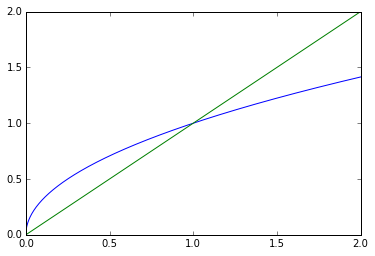

In [29]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

x = np.linspace(0, 2, 1000)
y1 = np.sqrt(x)
y2 = x

plt.plot(x, y1, x, y2)

In the case of `f(x) = sqrt(x)`, the fixed points are `0` and `1`, because `sqrt(1) = 1` and `sqrt(0) = 0`.


We wish we had a magic function `Y` that can take an arbitrary function `f` and tell us its fixed point `x` such that:
* `f(x) = x`
* `y(f) = x`

Without further ado, here is Y. I don't think I can do a better job explaining it than the sources that I read, so here they are:
* http://matt.might.net/articles/implementation-of-recursive-fixed-point-y-combinator-in-javascript-for-memoization/
* https://blog.jcoglan.com/2008/01/10/deriving-the-y-combinator/

In [30]:
Y = lambda F: (lambda x: F(lambda y:(x(x))(y)))(lambda x: F(lambda y:(x(x))(y))) 

### Wrapping Trick
We can make recursive functions by using the following trick in combination with the Y-Combinator. 
1. make a function whose fixed point is the function we actually care about
2. give this function to the Y combinator
3. give the resulting function the arguments you wanted to give originally

In [31]:
c_factorial_generator = lambda r: lambda n: IF(c_lt(n)(c2))(lambda: c1)(lambda: c_multiply(n)(r(c_predecessor(n))))

c_factorial = Y(c_factorial_generator)

In the future, all programs can be generated using this wrapping trick, minding that programs look a bit messier with lambda wrapping inside `IF` statements.

In [32]:
c_equal(1, c_factorial(c0))
c_equal(1, c_factorial(c1))
c_equal(2, c_factorial(c2))
c_equal(6, c_factorial(c3))